# Conversion Rate
@20200527 Chunlei Zhou
## Project Introduction
### Goal
1. Predict conversion rate;
2. Come up with recommendations for the product team and the marketing team to improve conversion rate.

### Data
The data set 'conversion_data.csv' has information about signed-in users during one session. Each row is a user session.

    Columns:
        country: user country based on the IP address;
        age: user age. Self-reported at sign-in step;
        new_user: whether the user created the account during this session (1) or had already an account and simply came back to the site (0);
        source: marketing channel source:
            Ads: came to the site by clicking on an advertisement
            Seo: came to the site by clicking on search results
            DirectL came to the site by directly typing the URL on the browser
        total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session
        converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything, in other words, not converted. The company goal is to increase converstion rate: #conversions/total sessions
### Initial Plan
Use supervise learning to build a model and recognize users that are likely to be converted.
Use the model to cluster user sessions to converted and not converted. 
Count converted sessions and divided by total number of sessions.

## Data Preprocessing

In [1]:
# load data
import pandas as pd
df = pd.read_csv('conversion_rate.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [2]:
# get data overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [3]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [4]:
# remove outlier

'''
from the describe above, we noticed the max age is 123. 
Typically, records of human lifespan above age 100 are highly susceptible to errors.
Thus, records with age above 100 are considered as outlier and should be removed.
'''

df = df[df['age'] < 100]

In [5]:
df.converted.value_counts()

0    306000
1     10198
Name: converted, dtype: int64

In [6]:
# Train-Test Split based on 7:2:1 rule
print('How large is 70% of the whole dataset?', round(df.shape[0]*0.7))
# Randomly choose 70% of total sample and save as train, 20% save as dev, and the leftovers are saved as test.
train = df.sample(frac =.7) # train models
dev = df.sample(frac =.2) # select model
test = df.sample(frac =.1)

How large is 70% of the whole dataset? 221339


## Exploratory Analysis

### Helper Functions

In [7]:
# Correlation Analysis using Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
def correlation_heatmap(dataset, width = None, length = None):
    '''
    This function will plot a heatmap for the input dataset to show correlation between different x_features and y
    Input: a dataset with x_features and y(last column)
    Output: a correlation heatmap
    '''
    if width and length:
        fig,ax = plt.subplots(figsize = (width, length))
    else:
        fig,ax = plt.subplots()
    ax = sns.heatmap(dataset.corr(),vmin = -1, vmax = 1, square = True, cmap = sns.diverging_palette(240, 10, as_cmap=True))
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    return ax

def groupcheck(df, feature, nrow =  None, ncol = None, width = None, length = None, font = None):
    fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(width, length))
    sns.countplot(x = feature, hue = 'converted', data = df, ax = ax[0])
    ax[0].set_title('Count Plot of ' + feature, fontsize = font)
    ax[0].set_yscale('log')
    sns.barplot(x=feature, y='converted', data=df, ax=ax[1]);
    ax[1].set_title('Conversion Rate per '+feature, fontsize = font)
    plt.tight_layout()
    plt.show()
    
# It seems that using histogram is more suitable for 'age' and 'total_pages_visited'.
def grouphist(df, feature:str, hist_kws, nrow =  None, ncol = None, width = None, length = None, font = None):
    grouped = df[[feature, 'converted']].groupby(feature).mean().reset_index()
    fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(width, length))
    sns.distplot(df[df['converted'] == 0][feature], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
    sns.distplot(df[df['converted'] == 1][feature], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
    ax[0].set_title('Count Plot of '+feature, fontsize=font)
    ax[0].legend()
    ax[1].plot(grouped[feature], grouped['converted'], '.-')
    ax[1].set_title('Conversion Rate vs. '+feature, fontsize=font)
    ax[1].set_xlabel(feature)
    ax[1].set_ylabel('convertion rate')
    ax[1].grid(True)
    plt.show()

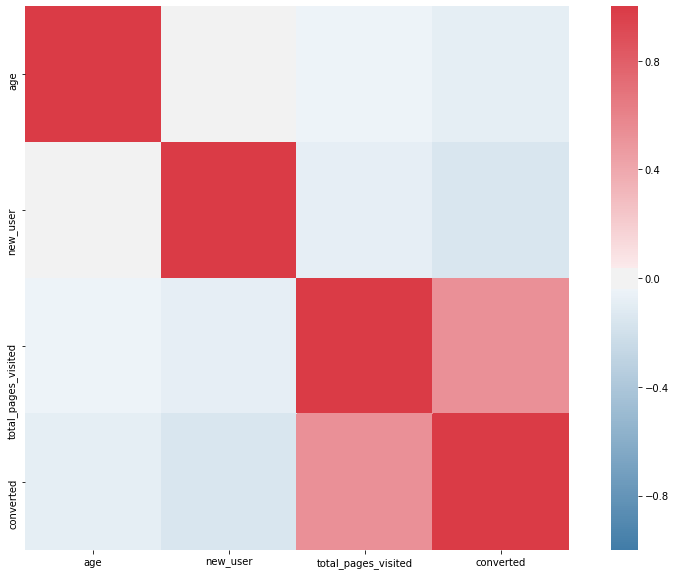

In [8]:
correlation_heatmap(df, width = 15, length = 10)

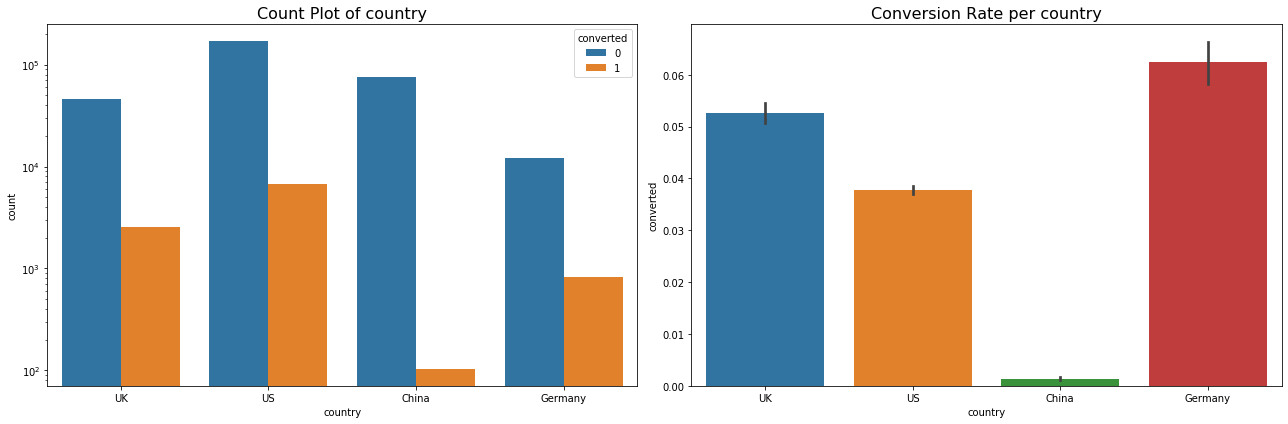

In [9]:
# Main purpose is to explore the relationship between features and conversion.
# 1. The relationship between country and converted
groupcheck(df, 'country', 1, 2, 18, 6, 16)

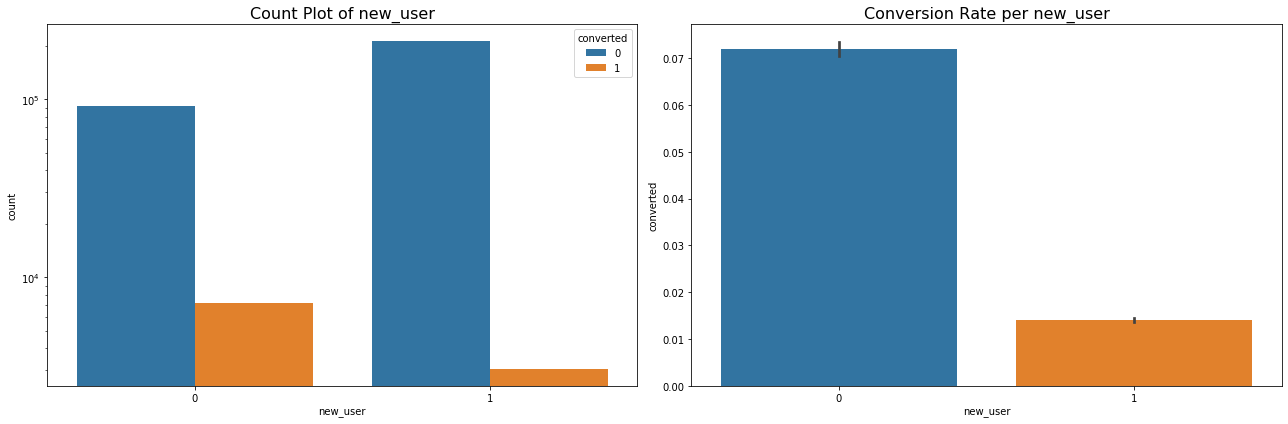

In [10]:
# 2. The relationship between new_user and converted
groupcheck(df, 'new_user', 1, 2, 18, 6, 16)

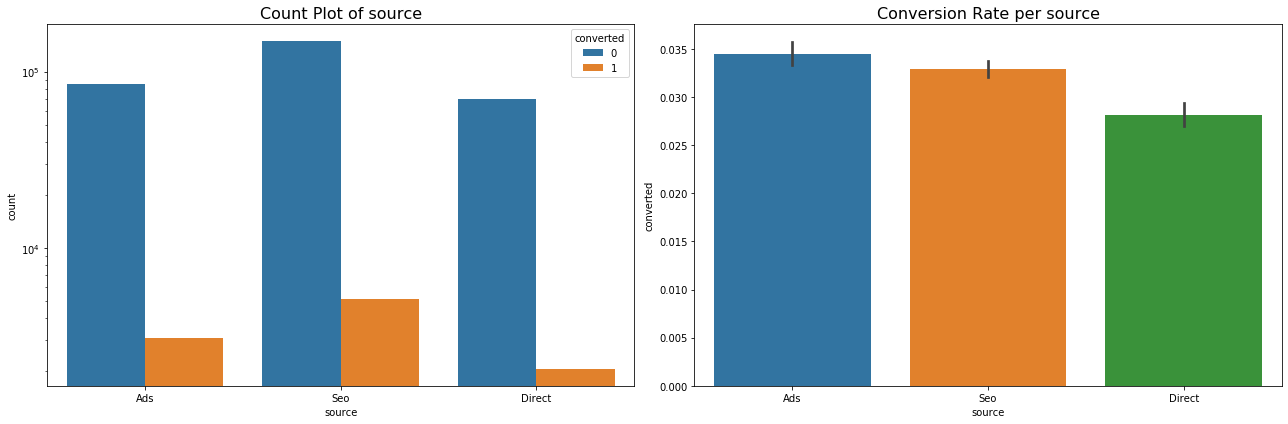

In [11]:
# 3. The relationship between new_user and converted
groupcheck(df, 'source', 1, 2, 18, 6, 16)

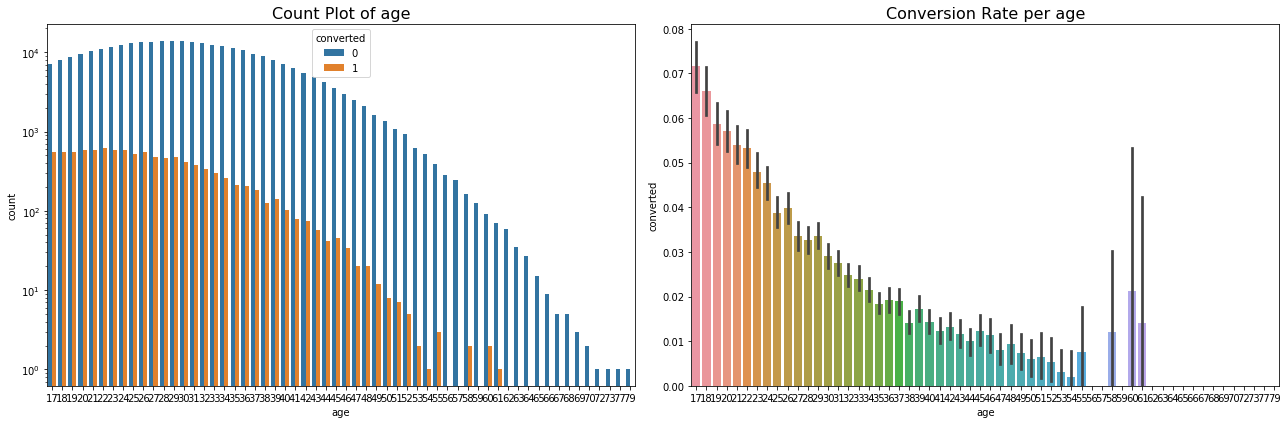

In [12]:
# 4. The relationship between age and converted
groupcheck(df, 'age', 1, 2, 18, 6, 16)

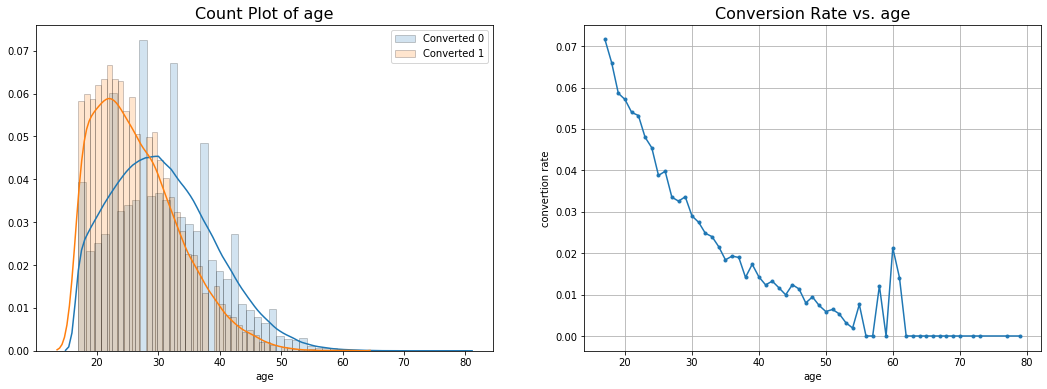

In [13]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
grouphist(df, 'age', hist_kws, 1, 2, 18, 6, 16)

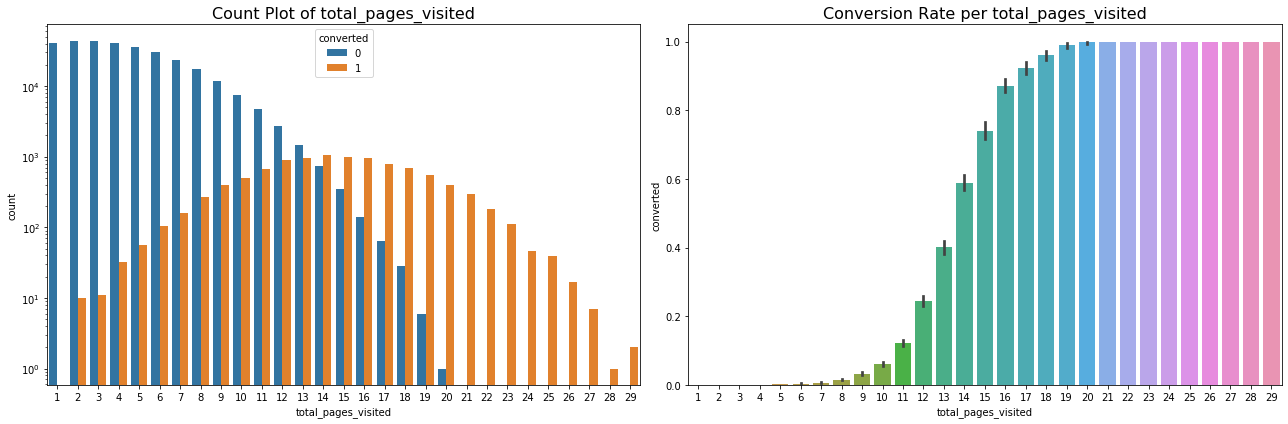

In [14]:
# 5. The relationship between total pages visited and converted
groupcheck(df, 'total_pages_visited', 1, 2, 18, 6, 16)

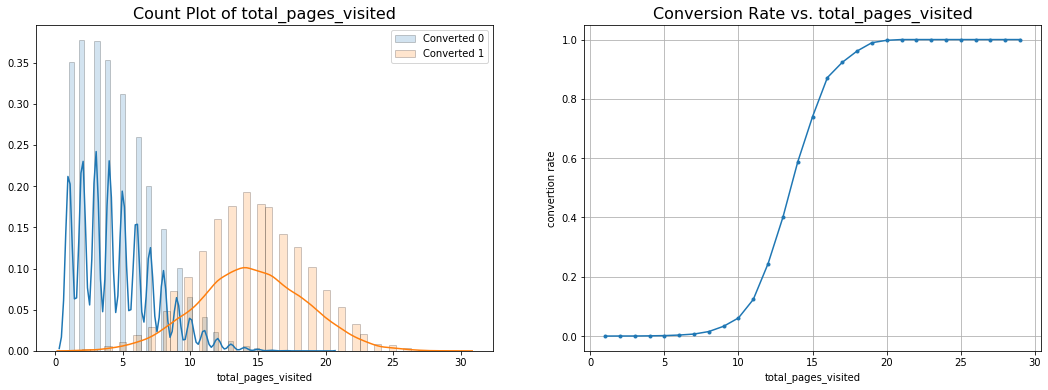

In [15]:
grouphist(df, 'total_pages_visited', hist_kws, 1, 2, 18, 6, 16)

## Models

In [16]:
# Build classification model based on the exploratory analysis
'''
It is a binary classification, we can use logistic regression, SVM, Random Forest, nerual network, and etc.
We will use training set to train all these models, use dev set to select the best model, 
and use the selected model to predict the conversion rate on test set.
'''
import sklearn
from sklearn.linear_model import LogisticRegression

train_y = train[['converted']]
train_x = train.iloc[:,:5]
dev_y = dev[['converted']]
dev_x = dev.iloc[:,:5]
test_y = test[['converted']]
test_x = test.iloc[:,:5]

# One-Hot encoding for categorical data: 'source' and 'country'
    # from sklearn.preprocessing import OneHotEncoder
    # enc = OneHotEncoder(handle_unknown='ignore')
    # train_x_arr = enc.fit_transform(train_x).toarray()

source_enc = pd.get_dummies(train_x.source, prefix='source')
country_enc = pd.get_dummies(train_x.country, prefix='country')
train_x = pd.concat([train_x, country_enc, source_enc], axis=1)
train_x = train_x.drop(columns=['country','source'])

source_enc = pd.get_dummies(dev_x.source, prefix='source')
country_enc = pd.get_dummies(dev_x.country, prefix='country')
dev_x = pd.concat([dev_x, country_enc, source_enc], axis=1)
dev_x = dev_x.drop(columns=['country','source'])

source_enc = pd.get_dummies(test_x.source, prefix='source')
country_enc = pd.get_dummies(test_x.country, prefix='country')
test_x = pd.concat([test_x, country_enc, source_enc], axis=1)
test_x = test_x.drop(columns=['country','source'])

### Model 1: Logistic Regression

In [17]:
# Train a logistic regression model
LR = LogisticRegression(multi_class = 'ovr')
LR_fitted = LR.fit(train_x,train_y)
# Prediction using logistic regression model
LR_prediction = LR_fitted.predict(dev_x)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Model 2: SVM

In [ ]:
from sklearn import svm
SVM = svm.LinearSVC()
SVM_fitted = SVM.fit(train_x, train_y)
SVM_prediction = SVM_fitted.predict(dev_x)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Model 3: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF_fitted = RF.fit(train_x, train_y)
RF_prediction = RF_fitted.predict(dev_x)

### Model 4: Neural Network

from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(hidden_layer_sizes=(22134, ),max_iter=1000,solver='lbfgs')
MLP_fitted = MLP.fit(train_x,train_y)
MLP_prediction = MLP_fitted.predict(dev_x)

#server break down... Give up this model

### Model Selection

In [ ]:
from sklearn.metrics import accuracy_score
print('''
Accuracy: 
- Logistic Regression: {:.2f}%
- SVM: {:.2f}%
- Random Forest: {:.2f}%
'''.format(100*accuracy_score(dev_y, LR_prediction), 
           100*accuracy_score(dev_y, SVM_prediction), 
           100*accuracy_score(dev_y, RF_prediction)))

According to the performance of each model, the model we selected is Random Forest.

## Make Prediction

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np

In [ ]:
# Plot the Confusion Matrix
def plot_confusion_matrix_improved(y_pred, y_true, width=None, length=None, title=None, normalize = False, cmap = None):
    '''
    This function visualizes the confusion matrix.
    Input: 
        y_pred: prediction of y;
        y_ture: truth
        width, length: figure size
        title: figure title
        normalize: normalize confusion matrix if normalize = True
        cmap: plot the given color map (map continue values to colors)
    Output: the visualized confusion matrix
    '''
    if width and length:
        fig, ax = plt.subplots(figsize = (width, length),constrained_layout=True)
    else:
        fig, ax = plt.subplots(constrained_layout=True)
    # Default title
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix (Not Normalized)'
    # Default color (Red)
    if not cmap:
        cmap = plt.cm.Reds
    # Compute Confusion Matrix
    cm = confusion_matrix(y_true,y_pred)
    # Class Labels
    labels = unique_labels(y_pred, y_true)
    # Normalization
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)
        fmt = '.2f'
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix without Normalization')
        fmt = 'd'
    im = ax.matshow(cm, cmap = cmap)
    ax.figure.colorbar(im)
    # Show all ticks and label them
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='Actual', xlabel='Prediction')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.xaxis.tick_bottom()
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=45)
    ax.grid(False)
    ax.title.set_fontsize(16)
    ax.xaxis.label.set_fontsize(14) 
    ax.yaxis.label.set_fontsize(14)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax

In [ ]:
prediction = RF_fitted.predict(test_x)
print('''
Prediction Accuracy: 
- Random Forest: {:.2f}%
'''.format(100*accuracy_score(test_y, prediction)))

In [ ]:
print(classification_report(test_y, prediction, 
                            target_names = ['Not Converted','Converted']))

In [ ]:
y = test_y['converted'].to_numpy()
y_actu = pd.Series(y, name='Actual')
y_pred = pd.Series(prediction, name='Predicted')

In [ ]:
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'])#, margins=True)
df_confusion

In [ ]:
df_conf_norm = df_confusion / df_confusion.sum(axis=1)
df_conf_norm

In [ ]:
plot_confusion_matrix_improved(prediction, y, width=15, length=10,
                               title='Confusion Matrix')

In [ ]:
from sklearn.metrics import auc, roc_curve
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(test_x.columns, RF_fitted.feature_importances_):
    feats[feature] = importance #add the name/value pair 
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini_importance'})
rank = importances.sort_values(by='Gini_importance')[::-1]
rank.plot(kind='bar', rot=-45)
# Print the feature ranking
print("Feature ranking:")
print(importances.sort_values(by='Gini_importance')[::-1])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
rank.reset_index(drop=False, inplace=True )
names = test_x.columns.tolist()
rank.reindex(names, axis=1)
sns.barplot(x = 'Gini_importance', y = 'index', data = rank)

In [ ]:
train_pred = RF_fitted.predict(train_x)

train_fpr, train_tpr, _ = roc_curve(train_y, train_pred)
dev_fpr, dev_tpr, _ = roc_curve(dev_y, RF_prediction)
test_fpr, test_tpr, _ = roc_curve(test_y, prediction)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
dev_auc = np.round(auc(dev_fpr, dev_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(dev_fpr, dev_tpr, label='Dev AUC: ' + str(dev_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [ ]:
conversion_rate = sum(prediction)/len(test)
actual_rate = sum(test_y['converted'])/len(test)
print('''
Conversion Rate (Test Set): 
- Predicted: {:.2f}%
- Actual: {:.2f}%
'''.format(100*conversion_rate,
          (100*actual_rate)))

In [ ]:
conversion_rate = sum(RF_prediction)/len(dev)
actual_rate = sum(dev_y['converted'])/len(dev)
print('''
Conversion Rate (Dev Set): 
- Predicted: {:.2f}%
- Actual: {:.2f}%
'''.format(100*conversion_rate,
          100*actual_rate))

In [ ]:
conversion_rate = sum(train_pred)/len(train)
actual_rate = sum(train_y['converted'])/len(train)
print('''
Conversion Rate (Train Set): 
- Predicted: {:.2f}%
- Actual: {:.2f}%
'''.format(100*conversion_rate,
          100*actual_rate))

In [ ]:
conversion_rate = (sum(train_pred) + sum(RF_prediction) + sum(prediction))/len(df)
actual_rate = sum(df['converted'])/len(df)
print('''
Conversion Rate (Total): 
- Predicted: {:.2f}%
- Actual: {:.2f}%
'''.format(100*conversion_rate,
          100*actual_rate))